In [1]:
'''
시나리오: disposable IoT 센서들에서 게이트웨이에게 센서 데이터를 전송(미싱 및 이상치 데이터 생성)
-> LSTM 기반의 데이터 전처리를 통한 데이터 복원 진행
-> 다수의 IOT 센서의 배터리 관리가 필요 (massive IoT application)
-> 데이터 전송주기 조절 진행하여, IoT 센서의 배터리 관리 
-> 전송주기조절 진행하는 이유? 실제 IOT 센서에서 수집되는 데이터의 경우, 대부분은 필요 없는 정보가 대다수 (ICNRG작성 드래프트 ref)
-> 필요없는 정보를 수집받지 않고, 필요한 정보만을 수집(데이터 전송주기 조절)
-> 데이터 예측에 기반한 데이터 전송 주기조절 -> 예측이 필요한 이유? 기존 상황을 얼마나 정확하게 예측하는지에 기반하여 데이터전송주기조절(식을 포함시킬 것)
-> 기존 문제점 1. 
1) IoT 센서데이터 예측에서 주기적인 패턴을 보이는 센서 데이터 값의 경우, 비교적 예측이 수월 LSTM 사용하여 높은 예측 정확도, 또는 룰 기반으로 진행
이벤트 발생 여부(사람의 수시로 왔다갔다 하거나, 문이 열리거나 등)에 따라서 센서 값의 변화가 큰 변화를 보이는 센서의 경우 한계를 지님
2) 배치되는 센서 대부분은 multimodal 센서로, 공간상의 다차원의 정보를 가지고 들어오게됨. 이에 대한 고려가 부족
=> 이미지 분류에서 사용되었던 방식을 사용하여, 센서가 가진 다차원 정보를 고려하고, 이벤트가 수시로 발생하는 환경에서 센서 데이터 값 예측을 진행
assumption) 현재는 다른 센서들이 주기적으로 데이터가 수집된다는 가정-> 시간 구간이 불규칙하게 들어올 때 고려 
대표적으로 미세먼지 센서가 이에 해당. 미세먼지 센서의 경우 이벤트에 따라서 값의 변화가 크게 발생하고, 주기적인 데이터 수집이 일어나지 않음
이는 추후 센서의 이상탐지도 가능할 것으로 기대-> 공간 상의 배치된 센서들에서 차원 간 정보간 상관관계는 높은편이므로, 이러한 상관관계가 어긋날 때, 

제안하는 방식) 이미지의 경우, 하나의 정보를 나타내기 위해선 연관성이 높은 픽셀이 주위에 배치됨. 
다른 위치에 배치된 센서간 상관관계를 분석하여, 높은 값을 나타내는 센서를 주위에 배치하여 데이터 셋을 구성하여 학습시킴

-> 구현방식: 임의로 아이디에 따라서 배치시킨 후, for 문으로 돌려서 이미지 구성
각 차원간 정보에서 동일 센서간 상관관계를 일정 윈도우 사이즈에서 뽑고, 그것을 기반으로 하여 이미지 데이터 셋 구성
1) 데이터를 윈도우 사이즈로 뽑기 
2) 상관관계 뽑기 ( 각 센서 간 ) -> 그것의 평균값으로 순위? (다른 방안 생각) 






-> 기존 
1. multimodal 센서의 수집되는 데이터간 상관관계 분석
하나의 센서 모듈에서 측정되는 정보들의 경우 상관관계가 깊음(ex. (온도, 습도), (pm2.5, pm10) .. )
다른 센서 모듈에서 수집하는 센서들의 경우, 상관관계가 거의 없음(다른 차원의 값으로 생각할 수 있을 듯)


(To do list) 
각 ID에 따라서 연계성의 순위가 모든 센서에서 동일하게 나타나는지 확인할 것

'''

'\n시나리오: disposable IoT 센서들에서 게이트웨이에게 센서 데이터를 전송(미싱 및 이상치 데이터 생성)\n-> LSTM 기반의 데이터 전처리를 통한 데이터 복원 진행\n-> 다수의 IOT 센서의 배터리 관리가 필요 (massive IoT application)\n-> 데이터 전송주기 조절 진행하여, IoT 센서의 배터리 관리 \n-> 전송주기조절 진행하는 이유? 실제 IOT 센서에서 수집되는 데이터의 경우, 대부분은 필요 없는 정보가 대다수 (ICNRG작성 드래프트 ref)\n-> 필요없는 정보를 수집받지 않고, 필요한 정보만을 수집(데이터 전송주기 조절)\n-> 데이터 예측에 기반한 데이터 전송 주기조절 -> 예측이 필요한 이유? 기존 상황을 얼마나 정확하게 예측하는지에 기반하여 데이터전송주기조절(식을 포함시킬 것)\n-> 기존 문제점 1. \n1) IoT 센서데이터 예측에서 주기적인 패턴을 보이는 센서 데이터 값의 경우, 비교적 예측이 수월 LSTM 사용하여 높은 예측 정확도, 또는 룰 기반으로 진행\n이벤트 발생 여부(사람의 수시로 왔다갔다 하거나, 문이 열리거나 등)에 따라서 센서 값의 변화가 큰 변화를 보이는 센서의 경우 한계를 지님\n2) 배치되는 센서 대부분은 multimodal 센서로, 공간상의 다차원의 정보를 가지고 들어오게됨. 이에 대한 고려가 부족\n=> 이미지 분류에서 사용되었던 방식을 사용하여, 센서가 가진 다차원 정보를 고려하고, 이벤트가 수시로 발생하는 환경에서 센서 데이터 값 예측을 진행\nassumption) 현재는 다른 센서들이 주기적으로 데이터가 수집된다는 가정-> 시간 구간이 불규칙하게 들어올 때 고려 \n대표적으로 미세먼지 센서가 이에 해당. 미세먼지 센서의 경우 이벤트에 따라서 값의 변화가 크게 발생하고, 주기적인 데이터 수집이 일어나지 않음\n이는 추후 센서의 이상탐지도 가능할 것으로 기대-> 공간 상의 배치된 센서들에서 차원 간 정보간 상관관계는 높은편이므로, 이러한 상관관계가 어긋날 때, \n\n제안하

In [2]:
import numpy as np

import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms

from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [3]:
## read dataset.excel file ##
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style='darkgrid',color_codes=True)
import os, inspect
from collections import deque
#import bb_model 
import math
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error
import pdb
import pymysql.cursors
import plotly as py
import plotly.graph_objects as go
# %matplotlib inline
import time
import datetime
#import chart_studio
import openpyxl
import os
from openpyxl import load_workbook
print (os.getcwd())
current_dir = os.path.dirname(os.path.abspath("__file__"))
try:
    TOT_EX_PATH = os.path.join(current_dir, 'datasetv2.xlsx')
#    TOT_EX_PATH.replace("\" , "/")
except:
    print('You should have to use file name with "modified department name". Check it')
print("TOT_EX_PATH:", TOT_EX_PATH)


'''
    str_pastDate = '2019-09-03 20:02'
    str_nowDate = '2019-10-02 20:00'
    29 days -> 20880
'''

dfs = pd.read_excel(TOT_EX_PATH)
tot_info = dfs

C:\Users\Admin\Dropbox\과제 정리\군집지능\업무보고, 월간보고, 회의록, 발표자료\[IoT군집지능]20191101_발표자료\IoT군집지능_20191003_발표자료준비v1
TOT_EX_PATH: C:\Users\Admin\Dropbox\과제 정리\군집지능\업무보고, 월간보고, 회의록, 발표자료\[IoT군집지능]20191101_발표자료\IoT군집지능_20191003_발표자료준비v1\datasetv2.xlsx


In [4]:
torch.cuda.is_available()

True

In [5]:
## sensor dataframe generation and index term extraction

print("dfs.keys():", dfs.keys())
df_index = dfs.keys()
sensor_df = dfs
sensor_index = list(set(sensor_df.keys())-set(['time']))
print('sensor_index:', sensor_index)

dfs.keys(): Index(['time', 'co2_41', 'h_41', 'pm025_41', 'pm100_41', 't_41', 'tvoc_41',
       'co2_42', 'h_42', 'pm025_42', 'pm100_42', 't_42', 'tvoc_42', 'co2_43',
       'h_43', 'pm025_43', 'pm100_43', 't_43', 'tvoc_43', 'co2_44', 'h_44',
       'pm025_44', 'pm100_44', 't_44', 'tvoc_44', 'co2_45', 'h_45', 'pm025_45',
       'pm100_45', 't_45', 'tvoc_45'],
      dtype='object')
sensor_index: ['pm025_42', 't_43', 't_42', 'tvoc_42', 't_41', 'tvoc_43', 'co2_42', 't_44', 'h_45', 'co2_41', 'tvoc_41', 'tvoc_45', 'tvoc_44', 'co2_44', 'h_44', 't_45', 'co2_45', 'pm100_42', 'pm100_41', 'pm025_41', 'co2_43', 'pm100_45', 'pm025_43', 'pm100_44', 'h_42', 'pm025_45', 'pm100_43', 'h_43', 'pm025_44', 'h_41']


In [6]:
## Check odd time stampe ## 
#timelist: sensor indexing set
checklist = []
totallist = []
for i in range(len(dfs['time'])):
    totallist.append(i)
    if int(str(dfs['time'][i]).split(':')[1])%2 == 1:
        checklist.append(i)
#print('Checklist:', checklist)
print('length of Checklist:', len(checklist))
timelist = set(totallist)-set(checklist)
timelist = list(timelist)

length of Checklist: 2688


In [7]:
## delete odd time stamp ##
# print(sensor_df)
sensor_df = sensor_df.drop(checklist)

In [8]:
## identifying the unreported time data ## 
temp_time = dict(zip(sensor_df['time'], sensor_df[sensor_index].values))
key_index = list(temp_time.keys())
error_index = []
for i in range(len(key_index)-1):
    if (int(str(key_index[i+1]).split(':')[1])-int(str(key_index[i]).split(':')[1]) != 2 and int(str(key_index[i+1]).split(':')[1])-int(str(key_index[i]).split(':')[1]) != -58):
        error_index.append(i)

print('Please check the excel file for time interval:', [key_index[i] for i in error_index])
## Check whether the excel data file is complete ## 
print(len(temp_time))

Please check the excel file for time interval: []
20880


In [9]:
## Change temp_time dictionary file to dataframe ##
sensor_dfs = pd.DataFrame(temp_time).T
sensor_dfs.columns = sensor_index
print('sensor_dfs_index:', sensor_index)

sensor_dfs_index: ['pm025_42', 't_43', 't_42', 'tvoc_42', 't_41', 'tvoc_43', 'co2_42', 't_44', 'h_45', 'co2_41', 'tvoc_41', 'tvoc_45', 'tvoc_44', 'co2_44', 'h_44', 't_45', 'co2_45', 'pm100_42', 'pm100_41', 'pm025_41', 'co2_43', 'pm100_45', 'pm025_43', 'pm100_44', 'h_42', 'pm025_45', 'pm100_43', 'h_43', 'pm025_44', 'h_41']


In [10]:
## missing data imputatation by prior  time data substitution ## 
''' 
please run two times this code for checking the missing data
'''
li = []
li_in = []
u = 0
df_index = sensor_index

for i in range(len(df_index)):
    u = 0
    li.append('index_slice')
    li_in.append('index_slice')
    print("length of dfs["+str(df_index[i])+"]:"+str(len(sensor_dfs[df_index[i]])) )
    for j in range(len(sensor_dfs[df_index[0]])):
        
        if np.isnan(sensor_dfs[df_index[i]][j]):
            try:
                sensor_dfs[df_index[i]][j] = sensor_dfs[df_index[i]][j-1] 
                li.append(sensor_dfs[df_index[i]][j])
                li_in.append(u)
            except:
                print("there is no substitutional number.")
        u = u+1
print(li_in)

length of dfs[pm025_42]:20880
length of dfs[t_43]:20880
length of dfs[t_42]:20880
length of dfs[tvoc_42]:20880
length of dfs[t_41]:20880
length of dfs[tvoc_43]:20880
length of dfs[co2_42]:20880
length of dfs[t_44]:20880
length of dfs[h_45]:20880
length of dfs[co2_41]:20880
length of dfs[tvoc_41]:20880
length of dfs[tvoc_45]:20880
length of dfs[tvoc_44]:20880
length of dfs[co2_44]:20880
length of dfs[h_44]:20880
length of dfs[t_45]:20880
length of dfs[co2_45]:20880
length of dfs[pm100_42]:20880
length of dfs[pm100_41]:20880
length of dfs[pm025_41]:20880
length of dfs[co2_43]:20880
length of dfs[pm100_45]:20880
length of dfs[pm025_43]:20880
length of dfs[pm100_44]:20880
length of dfs[h_42]:20880
length of dfs[pm025_45]:20880
length of dfs[pm100_43]:20880
length of dfs[h_43]:20880
length of dfs[pm025_44]:20880
length of dfs[h_41]:20880


['index_slice', 94, 1128, 4763, 9232, 9863, 11547, 12192, 12205, 12271, 12970, 13772, 14796, 14942, 15058, 15521, 15611, 16176, 16414, 16420, 16520, 16563, 17204, 20669, 'index_slice', 506, 4135, 4730, 4731, 4750, 5053, 8870, 9247, 9863, 10720, 11356, 13283, 14164, 15611, 16374, 17202, 19938, 19961, 'index_slice', 94, 1128, 4763, 9232, 9863, 11547, 12192, 12205, 12271, 12970, 13772, 14796, 14942, 15058, 15521, 15611, 16176, 16414, 16420, 16520, 16563, 17204, 20669, 'index_slice', 94, 1128, 4763, 9232, 9863, 11547, 12192, 12205, 12271, 12970, 13772, 14796, 14942, 15058, 15521, 15611, 16176, 16414, 16420, 16520, 16563, 17204, 20669, 'index_slice', 2, 9, 23, 31, 58, 75, 77, 84, 110, 117, 123, 128, 130, 132, 133, 135, 179, 182, 183, 187, 190, 192, 194, 203, 205, 206, 218, 219, 223, 225, 233, 236, 240, 245, 292, 293, 294, 295, 296, 297, 299, 300, 302, 303, 304, 312, 316, 322, 328, 334, 338, 342, 345, 346, 348, 349, 351, 352, 353, 354, 356, 357, 361, 366, 370, 386, 396, 406, 414, 415, 416, 4

In [11]:
## sensor index arrange by ID ##
## To do list: 센서의 이름별로 정렬하기
## new_df_index : 센서 ID별로 정렬된 리스트
## split_index: 센서 ID별로 하나의 리스트를 만듬 -> 각 센서 ID 별로 correlation 비교 하기 위해

new_df_index = []
num_sensor = 5
split_index = []

j= 41
for k in range(num_sensor):
    split_index.append([])
#     print(split_index)

for j in range(41, 41+num_sensor):
#     split_index.append([])
    for i in range(0,len(df_index)):
        if df_index[i].split('_')[1] == str(j):
            new_df_index.append(df_index[i])
            split_index[j-41].append(df_index[i])
    j = j+1
print('new_df_index:', new_df_index)
print('=============================')
print('split_index:', split_index)

sensor_dfs = sensor_dfs[new_df_index]

new_df_index: ['t_41', 'co2_41', 'tvoc_41', 'pm100_41', 'pm025_41', 'h_41', 'pm025_42', 't_42', 'tvoc_42', 'co2_42', 'pm100_42', 'h_42', 't_43', 'tvoc_43', 'co2_43', 'pm025_43', 'pm100_43', 'h_43', 't_44', 'tvoc_44', 'co2_44', 'h_44', 'pm100_44', 'pm025_44', 'h_45', 'tvoc_45', 't_45', 'co2_45', 'pm100_45', 'pm025_45']
split_index: [['t_41', 'co2_41', 'tvoc_41', 'pm100_41', 'pm025_41', 'h_41'], ['pm025_42', 't_42', 'tvoc_42', 'co2_42', 'pm100_42', 'h_42'], ['t_43', 'tvoc_43', 'co2_43', 'pm025_43', 'pm100_43', 'h_43'], ['t_44', 'tvoc_44', 'co2_44', 'h_44', 'pm100_44', 'pm025_44'], ['h_45', 'tvoc_45', 't_45', 'co2_45', 'pm100_45', 'pm025_45']]


In [12]:
## sensor data differential value list generation ##
## sensor index: new_df_index ## 
diff_list = []
for i in new_df_index:
    temp_diff = np.array(sensor_dfs[i][1:])-np.array(sensor_dfs[i][0:-1])
    temp_diff = np.hstack((0,temp_diff))
    diff_list.append(temp_diff)
# diff_list.append(np.array(sensor_dfs[a][1:])-np.array(sensor_dfs[a][0:-1]))


In [13]:
## Compare the correlation coefficient between 2 snesor IDs ##
## comp_index _1 : first sensor ID 
## comp_index_2 : second sensor ID

comp_index_1 = 41
comp_index_2 = 42

new_split_index =[]
new_split_index = split_index[comp_index_1-41] + split_index[comp_index_2-41]
#sensor_dfs[new_split_index]
sensor_dfs[new_split_index].corr(method='pearson')

#sensor_dfs[new_split_index][:100].corr(method='pearson')
# S_df = sensor_dfs[split_index[0]]
# sensor_dfs.corr(method='pearson')



,t_41,co2_41,tvoc_41,pm100_41,pm025_41,h_41,pm025_42,t_42,tvoc_42,co2_42,pm100_42,h_42
t_41,1.000000,-0.265122,-0.265176,-0.056734,-0.005392,-0.616044,-0.016171,0.990661,-0.458408,-0.458588,-0.044320,-0.555419
co2_41,-0.265122,1.000000,0.999906,0.169779,0.153922,0.082163,0.162248,-0.279858,0.751325,0.751109,0.175448,0.090168
tvoc_41,-0.265176,0.999906,1.000000,0.169387,0.153513,0.082128,0.161769,-0.279864,0.751846,0.751629,0.175030,0.090120
pm100_41,-0.056734,0.169779,0.169387,1.000000,0.974399,0.170705,0.961115,-0.050902,0.317928,0.317991,0.965170,0.180960
pm025_41,-0.005392,0.153922,0.153513,0.974399,1.000000,0.156920,0.982668,0.002278,0.305718,0.305769,0.963647,0.170846
h_41,-0.616044,0.082163,0.082128,0.170705,0.156920,1.000000,0.178975,-0.595354,0.277153,0.277296,0.189350,0.983444
pm025_42,-0.016171,0.162248,0.161769,0.961115,0.982668,0.178975,1.000000,-0.009516,0.317008,0.317043,0.982147,0.195240
t_42,0.990661,-0.279858,-0.279864,-0.050902,0.002278,-0.595354,-0.009516,1.000000,-0.449810,-0.449997,-0.038715,-0.553498
tvoc_42,-0.458408,0.751325,0.751846,0.317928,0.305718,0.277153,0.317008,-0.449810,1.000000,0.999992,0.321183,0.256033
co2_42,-0.458588,0.751109,0.751629,0.317991,0.305769,0.277296,0.317043,-0.449997,0.999992,1.000000,0.321210,0.256166


In [14]:
# print(new_split_index)
# print(len(new_split_index))
## Choose the sensor ID with close relationship to the set
## corr_array: 비교하고자 하는 상관계수를 나타내는 센서 ID (2개) 
## corr_list: 상관계수가 큰 값들을 나타내는 집합
## To do list: 딕셔너리로 하면 편할 것 같음

corr_array = np.array(sensor_dfs[new_split_index].corr(method='pearson'))   
corr_list = []
threshold = 0.5


for i in range(len(new_split_index)):
    corr_list.append([])
    for j in range(len(new_split_index)):
        if abs(corr_array[i][j]) > threshold:
            corr_list[i].append(new_split_index[j])
        corr_list[i]= list(set(corr_list[i])-set([new_split_index[i]]))
corr_list1 = dict(zip(new_split_index, corr_list))
print(corr_list1)
# for i in range(len(new_split_index)):
#     corr_list[i].append(list(set(corr_list[i])-set(new_split_index[i])))


{'t_41': ['h_42', 't_42', 'h_41'], 'co2_41': ['tvoc_41', 'co2_42', 'tvoc_42'], 'tvoc_41': ['co2_42', 'tvoc_42', 'co2_41'], 'pm100_41': ['pm025_42', 'pm100_42', 'pm025_41'], 'pm025_41': ['pm025_42', 'pm100_42', 'pm100_41'], 'h_41': ['t_41', 'h_42', 't_42'], 'pm025_42': ['pm100_42', 'pm100_41', 'pm025_41'], 't_42': ['t_41', 'h_42', 'h_41'], 'tvoc_42': ['tvoc_41', 'co2_42', 'co2_41'], 'co2_42': ['tvoc_41', 'tvoc_42', 'co2_41'], 'pm100_42': ['pm025_42', 'pm100_41', 'pm025_41'], 'h_42': ['t_41', 't_42', 'h_41']}


In [15]:
## select traget_index and train_index ##
'''
target 하는 sensor와 같은 ID를 가지는 센서들은 학습에 사용되지 않음
같은 차원의 정보를 나타내는 인덱스를 모아놓아야함

'''

train_index = list(new_df_index)
#train_index.remove('time')
target_index = 'pm025_44'
target_num = target_index.split('_')[1]
remove_index = []
for i in train_index:
    if i.split('_')[1] == target_num:
#       print(i)
        remove_index.append(i)

# delete the same target_index ID in train_index
for i in remove_index:
    train_index.remove(i)
print('target_num:{}, train_index:{}'.format(target_num, train_index))

co2_index = []
temper2_index = [] 
pm2_index = []

# sorting by same ID 
for i in train_index: 
    if i.split('_')[0] in ['tvoc','co2']:
        co2_index.append(i)
    elif i.split('_')[0] in ['t','h']:
        temper2_index.append(i)
    else:
        pm2_index.append(i)

print('co2_index:{}, temper2_index:{}, pm2_indx:{}'.format(co2_index, temper2_index, pm2_index))

target_num:44, train_index:['t_41', 'co2_41', 'tvoc_41', 'pm100_41', 'pm025_41', 'h_41', 'pm025_42', 't_42', 'tvoc_42', 'co2_42', 'pm100_42', 'h_42', 't_43', 'tvoc_43', 'co2_43', 'pm025_43', 'pm100_43', 'h_43', 'h_45', 'tvoc_45', 't_45', 'co2_45', 'pm100_45', 'pm025_45']
co2_index:['co2_41', 'tvoc_41', 'tvoc_42', 'co2_42', 'tvoc_43', 'co2_43', 'tvoc_45', 'co2_45'], temper2_index:['t_41', 'h_41', 't_42', 'h_42', 't_43', 'h_43', 'h_45', 't_45'], pm2_indx:['pm100_41', 'pm025_41', 'pm025_42', 'pm100_42', 'pm025_43', 'pm100_43', 'pm100_45', 'pm025_45']


In [16]:
'''
연관관계가 높은 순서대로 배치, 인덱스의 첫번째 값을 제일 위의 이미지로 구성하고, 
상관계수가 높은 순서대로 배치
'''

co_index = copy.deepcopy(co2_index)
temper_index = copy.deepcopy(temper2_index)
pm_index = copy.deepcopy(pm2_index)


seq_list = []
for j in [co_index, temper_index, pm_index]:
    cur_sensor = j[0]
    cur_seq_list = [cur_sensor]
    for i in range(len(j)-1):
        temp_list = list(sensor_dfs[j].corr(method='pearson')[cur_sensor])
        max_val = abs(temp_list[0])
        second_val = abs(temp_list[1])
        for i in range(1,len(temp_list)):
            if abs(temp_list[i]) > max_val:
                second_val = max_val
                max_val = abs(temp_list[i])
            else:
                if abs(temp_list[i]) > second_val:
                    second_val = abs(temp_list[i])
        next_idx = [j[i] for i in range(len(temp_list)) if abs(temp_list[i]) == second_val]
#         print(next_idx)
        cur_seq_list.append(next_idx[0])
        j.remove(cur_sensor)
        cur_sensor = next_idx[0]
    seq_list.append(cur_seq_list)
print('seq_list:',seq_list)

seq_list: [['co2_41', 'tvoc_41', 'tvoc_42', 'co2_42', 'tvoc_43', 'co2_43', 'tvoc_45', 'co2_45'], ['t_41', 't_42', 't_45', 'h_43', 'h_45', 'h_42', 'h_41', 't_43'], ['pm100_41', 'pm025_41', 'pm025_42', 'pm100_42', 'pm025_45', 'pm100_45', 'pm025_43', 'pm100_43']]


In [17]:
# Global Variable For training
# You just use the following hyper-parameters
BATCH_SIZE = 20
NUM_EPOCH = 200
LEARNING_RATE = 0.01
CRITERION = nn.MSELoss()

In [18]:
## training data 정렬 및 0~1 사이로 scale ## 
## 3 x 8 x 20880 으로 이루어짐 
## 1번은 tvoc 관련, 2번은 h,t 관련, 3번은 pm 관련 센서들 집합

train_scaler = []
train_nptf_li =[]
target_scaler = []
target_nptf =[]
scaler = MinMaxScaler(feature_range=(0, 1))
for i in seq_list:
    u = 0
    temp_train_scaler = []
    temp_train_nptf_li =[]
    for j in i:
        temp_train_scaler.append(np.array(sensor_dfs[j]).reshape(-1,1).astype('float32'))
        temp_train_nptf_li.append(scaler.fit_transform(temp_train_scaler[u]))
        u = u + 1
    train_scaler.append(temp_train_scaler)
    train_nptf_li.append(temp_train_nptf_li)
print(len(train_nptf_li))
target_scaler = np.array(sensor_dfs[target_index]).reshape(-1,1).astype('float32')
target_nptf = scaler.fit_transform(target_scaler)        

3


In [19]:
total_list = []
total_list = list(train_nptf_li)
# total_list.append(target_nptf.reshape(1,20880) )
total_list_v1 = np.array(total_list)
print('total_list_v1.shape:', total_list_v1.shape)

total_list_v1.shape: (3, 8, 20880, 1)


In [20]:
## 90%를 학습 데이터로 사용하고 10%를 테스트하는 데이터로 사용 ## 
## 3 x 8 x 20880에서 20880을 나눔 ## 

train_len = 0.9
train = [] 
test = []
print(len(total_list_v1[0]))
for i in range(len(total_list_v1)):
    temp_train = [] 
    temp_test = []
    for j in range(len(total_list_v1[0])):
        temp_train.append(total_list_v1[i][j][ : int(len(total_list_v1[0][0])*train_len)])
        temp_test.append(total_list_v1[i][j][int(len(total_list_v1[0][0])*train_len): ])
        
    train.append(temp_train)
    test.append(temp_test)

    
train = np.array(train)
test = np.array(test)
# train = total_list_v1[:, :, : int(len(total_list_v1[0])*train_len)]
# test  = total_list_v1[:, :, int(len(total_list_v1[0])*train_len): ]
# train.append(target_nptf)
print('train length: ({},{},{}), test length: ({},{},{})'.format(len(train),len(train[0]),len(train[0][0]), len(test),len(test[0]),len(test[0][0])))

8
train length: (3,8,18792), test length: (3,8,2088)


In [21]:
 ###### ----------data set-----------######
 '''
 예측되는 데이터는 이용하지 않고 사용
 주기조절 하므로, 자신의 데이터를 예측에 사용하지 않음 

 mode: 1이면 다음 스텝 예측, 2이면 현재 스텝 예측
 '''
mode = 2

look_back = 32
estimated_len = 1

def create_dataset(traindataset,testdataset, look_back,estimated_len, mode):
    dataX, dataY = [], []
    if mode == 2:
        for i in range(len(traindataset[0][0])-look_back-1-estimated_len):
            a = traindataset[ : , : , i:(i + look_back)]
            dataX.append(a)
            dataY.append(testdataset[(i + look_back-1): (i + look_back-1 + estimated_len)])
        return np.array(dataX), np.array(dataY)
    else:
        for i in range(len(traindataset[0])-look_back-1-estimated_len):
            a = traindataset[: , :, i:(i + look_back)]
            dataX.append(a)
            dataY.append(testdataset[(i + look_back): (i + look_back + estimated_len)])
        return np.array(dataX), np.array(dataY)

In [22]:
## Eucledian distance 구하기 + 기울기 값의 변화율 보기 ##
## 0~1로 normalized 된 벡터를 사용해야함## 
def dist_cal(comp_sn1, comp_sn2):
    
#     ini = 0
#     time_interval = 32
#     comp_sn1 = 'tvoc_41'
#     comp_sn2 = 'co2_41'
    diff_val = abs(comp_sn1-comp_sn2)
    Eu_dist = sum(diff_val**2)

    temp_slope = (np.array(diff_val[1:]) - np.array(diff_val[0:-1]))
    slope_val = np.zeros(len(temp_slope))
    div_factor = len(temp_slope)*(len(temp_slope)+1)/2
    #print(div_factor)
    for i in range(1,len(temp_slope)+1):
        slope_val[i-1] = temp_slope[i-1]*i/div_factor
        #print(i/len(temp_slope))

   # print(Eu_dist)    
   # print('slope_val:',slope_val)
   # print('abs(slope_val):', abs(slope_val))
    
    return Eu_dist + sum(abs(slope_val))
    #range(len(diff_val))/len(diff_val)
    # print('sensor_dfs[comp_sn2]:', sensor_dfs[comp_sn2][ini:time_interval])
    # print('sensor_dfs[comp_sn1]:', sensor_dfs[comp_sn1][ini:time_interval])





In [23]:
trainX[0].shape

NameError: name 'trainX' is not defined

In [ ]:
seq_list[0]

In [ ]:
t1_value = trainX[0][0][1]
t2_value = trainX[0][0][2]

In [ ]:
train_X1.shape

In [ ]:
list(train_X[0][0])[0]

In [ ]:
train_X = trainX.copy()
for i in range(len(train_X)):
    train_X[i]
    for j in range(len(train_X[0])):
        cur_list = copy.deepcopy(seq_list[j])
        t1_index = cur_list[0]
        m = 0 
        distance_val = []
        temp_val1 = list(train_X[i][j])
        for n in range(0,len(cur_list)-1):
            t1_value = temp_val1[m]
            temp_val1.remove(temp_val1[m])
            for k in range(0,len(cur_list)-1):
                t2_value = temp_val1[k]
                distance_val.append(dist_cal(t1_value, t2_value))
                m = [b for b in range(len(cur_list)-1) if distance_val[b] == min(distance_val)]
            cur_list.remove(cur_list(m))
            
            
            for n in range(len(cur_list)):
                comp_sn1 = cur_list 
            cur_list[k]

In [247]:
len(temp_val1)

8

In [249]:
cur_list

['tvoc_41',
 'co2_41',
 'tvoc_42',
 'co2_42',
 'tvoc_43',
 'co2_43',
 'tvoc_45',
 'co2_45']

In [264]:
i = 0
j = 0
cur_list = copy.deepcopy(seq_list[0])
t1_index = cur_list[0]
m = 0 
print('temp_val1[m]:',temp_val1[m])
temp_val1 = list(train_X[i][j])

for n in range(0,len(cur_list)-1):
    t1_value = temp_val1[m]
    print('t1_vale.shape:', t1_value.shape)
    del temp_val1[m]
    print('temp_val1 length:',len(temp_val1))
    distance_val = []
    for k in range(len(temp_val1)):
        t2_value = temp_val1[k]
        distance_val.append(dist_cal(t1_value, t2_value))
        print('len of distance_val:',len(distance_val))
    #print(distance_val)
    m = [b for b in range(len(temp_val1)) if distance_val[b] == min(distance_val)][0]
    print('m:',m)
    print('temp_val1[m]:',temp_val1[m])

temp_val1[m]: [0.07395834 0.07395834 0.07395834 0.07395834 0.07395834 0.07395834
 0.07395834 0.07395834 0.07395834 0.07395834 0.07395834 0.07395834
 0.07395834 0.07395834 0.07395834 0.07395834 0.07395834 0.07395834
 0.07395834 0.04166667 0.04583333 0.07395834 0.07395834 0.07395834
 0.07395834 0.07395834 0.07395834 0.07395834 0.07395834 0.07395834
 0.07395834 0.03854167]
t1_vale.shape: (32,)
temp_val1 length: 7
len of distance_val: 1
len of distance_val: 2
len of distance_val: 3
len of distance_val: 4
len of distance_val: 5
len of distance_val: 6
len of distance_val: 7
m: 0
temp_val1[m]: [0.13793105 0.13793105 0.13793105 0.19967926 0.13793105 0.13793105
 0.10986367 0.16920608 0.10986367 0.10986367 0.13793105 0.10986367
 0.13793105 0.12269446 0.1531676  0.16920608 0.19967926 0.13793105
 0.13793105 0.19967926 0.13793105 0.19967926 0.13793105 0.13793105
 0.13793105 0.13793105 0.13793105 0.19967926 0.13793105 0.13793105
 0.13793105 0.13793105]
t1_vale.shape: (32,)
temp_val1 length: 6
len of

In [127]:
seq_list

[['tvoc_41',
  'co2_41',
  'tvoc_42',
  'co2_42',
  'tvoc_43',
  'co2_43',
  'tvoc_45',
  'co2_45'],
 ['h_41', 'h_42', 't_41', 't_42', 't_45', 'h_43', 'h_45', 't_43'],
 ['pm025_41',
  'pm025_42',
  'pm100_42',
  'pm100_41',
  'pm025_45',
  'pm100_45',
  'pm025_43',
  'pm100_43']]

In [145]:
## trainX[0][0][0] -> tvoc_41의 1번째 데이터
## trainX[0][0][1] -> tvoc41의 2번째 데이터..
## seq_list에 따라서 생각하면 됨
trainX.shape[-1]






32

In [38]:
## train, test data 생성 ##
trainX, trainY = create_dataset(train, target_nptf[ : int(len(total_list_v1[0][0])*train_len)], look_back,estimated_len, 2)
testX, testY = create_dataset(test,target_nptf[int(len(total_list_v1[0][0])*train_len): ] ,look_back,estimated_len, 2)
trainX = trainX.reshape(len(trainX),len(trainX[0]), len(trainX[0][0]), -1)
testX = testX.reshape(len(testX),len(testX[0]), len(testX[0][0]), -1)
testY = testY.reshape(len(testY),-1)
trainY = trainY.reshape(len(trainY),-1)
print('trainX shape: {}, trainY shape: {}, testX shape: {}, testY shape: {}'.format(trainX.shape, trainY.shape,testX.shape,testY.shape))

trainX shape: (18758, 3, 8, 32), trainY shape: (18758, 1), testX shape: (2054, 3, 8, 32), testY shape: (2054, 1)


In [41]:
'''
trainData.shape:((18760, 2))
testData.shape:((2056, 2))
18760개의 Data, 
trainData[0][0]-> (3, 8, 30)
trainData[0][1]-> (1)
'''

trainData = []
testData = []
for i in range(len(trainX)):
    trainData.append([trainX[i],trainY[i]])
for i in range(len(testX)):
    testData.append([testX[i],testY[i]])
# trainData = np.array(trainData)
# testData = np.array(testData)
# print('trainData.shape:({})'.format(trainData.shape))
# print('testData.shape:({})'.format(testData.shape))

In [42]:
train_loader = torch.utils.data.DataLoader(dataset=trainData, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=testData, batch_size=BATCH_SIZE, shuffle=False)

In [459]:
# for i, data in enumerate(train_loader):
#     print(len(data))

In [45]:
def fit(model,train_loader):
    model.train()
    device = next(model.parameters()).device.index # model parameter 안에 디바이스 해당 인덱스가 뽑힘
    optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
    losses = []
    for i, data in enumerate(train_loader):
       
        raw = data[0].type(torch.FloatTensor).cuda(device)
        label = data[1].type(torch.FloatTensor).cuda(device)
        
        pred_label = model(raw)
#         print(pred_label, label)
        loss = CRITERION(pred_label, label)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    avg_loss = sum(losses)/len(losses)
    return avg_loss

In [46]:
def eval(model, test_loader):
    model.eval()
    device = next(model.parameters()).device.index
    pred_labels = []
    real_labels = []

    for i, data in enumerate(test_loader):
        raw = data[0].type(torch.FloatTensor).cuda(device)
        label = data[1].type(torch.FloatTensor).cuda(device)
        real_labels += list(label.cpu().detach().numpy())
        
        pred_label = model(raw)
        pred_label = list(pred_label.cpu().detach().numpy())
        pred_labels += pred_label
        
    real_labels = np.array(real_labels)
    pred_labels = np.array(pred_labels)
  # pred_labels = pred_labels.argmax(axis=1)
    acc = sum((real_labels-pred_labels))**2/len(real_labels)
    
    return acc, pred_labels,real_labels

# Task1: Compare between simple MLP and simple CNN

### MLP

In [47]:
inputsize = 3*8*32
layer_1 = 3*16*16
layer_2 = 3*12*12
layer_3 = 3*6*6
layer_4 = 4*4*4
layer_5 = 4*2*2
layer_6 = 4*1*1
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        # Fully-connected layer
        self.fc1_1 = nn.Linear(inputsize, layer_1)
        self.act1_1 = nn.ReLU()
        self.fc1_2 = nn.Linear(layer_1, layer_2)
        self.act1_2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        
        self.fc2_1 = nn.Linear(layer_3, layer_4)
        self.act2_1 = nn.ReLU()
        self.fc2_2 = nn.Linear(layer_4, layer_5)
        self.act2_2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)

        # Output layer
        self.out = nn.Linear(layer_6, 1)
        
    def forward(self, x):
        x = x.view(-1, inputsize)
        
        x = self.act1_1(self.fc1_1(x))
        x = self.act1_2(self.fc1_2(x))
        x = x.view(-1, 3,12,12)
        x = self.pool1(x)
        x = x.view(-1, layer_3)
        
        x = self.act2_1(self.fc2_1(x))
        x = self.act2_2(self.fc2_2(x))
        x = x.view(-1, 4,2,2)
        x = self.pool2(x)
        x = x.view(-1, layer_6)

        out = self.out(x)
        return out

In [48]:
mlp_model = SimpleMLP().cuda()
train_loss1 = []
test_accuracy1 = []
for epoch in tqdm(range(NUM_EPOCH)):
    train_loss1.append(fit(mlp_model, train_loader))
    #return avg_loss, pred_label,label
    test_accuracy1.append(eval(mlp_model, test_loader))
    #return acc, pred_label,label
summary(mlp_model, input_size = (len(trainX[0]),len(trainX[0][0]),len(trainX[0][0][0])))

  0%|▍                                                                                 | 1/200 [00:04<14:27,  4.36s/it]


KeyboardInterrupt: 

In [104]:

# plt.plot(test_accuracy1, 'r', linestyle='-', label='MLP')
# plt.plot(test_accuracy2, 'b', linestyle='-', label='CNN')
# plt.title('Test Accuracy')
# plt.xlabel('epoch')
# plt.ylabel("test accuracy")
# plt.ylim(0,70)
# plt.xlim(0,50)
# plt.legend()
# plt.show()

Train Score: 6.81 RMSE


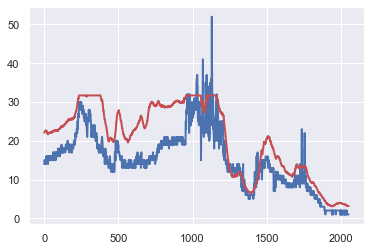

In [464]:
target_nptf = scaler.fit_transform(target_scaler) 
testacc1 = np.array(test_accuracy1)
realData = scaler.inverse_transform(testacc1[199][2])
predictData_MLP = scaler.inverse_transform(testacc1[199][1])
# plt.plot(realData)
# plt.plot(predictData_MLP)
testScore_MLP = math.sqrt(mean_squared_error(realData, predictData_MLP))
print('Train Score: %.2f RMSE' % testScore_MLP)

plt.plot(realData, 'b-', label='reported data',linewidth =2.0)
plt.plot(predictData_MLP, 'r-', label ='raw data', linewidth =2.0)

In [291]:
# plt.plot(sensor_dfs['pm025_44'][-2000:])

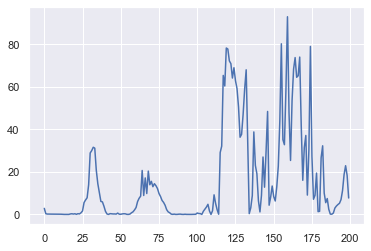

In [286]:
## 가장 작은 test error 가지는 epcoh 찾기 ## 
## 13정도 일듯 ##
plt.plot(testacc1[:,0])

### CNN

In [465]:
## 기존 이미지 사이즈 3 x 8 x 32 ##
class SimpleCNN(nn.Module):
    def __init__(self):
        # MaxPool default : kernel size와 같음
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 3, 2) # (3,8,32) -> (3,7,31)
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
        self.act1_1 = nn.ReLU() 
        self.conv2 = nn.Conv2d(3, 3, 2) # (3,7,31) -> (3,6,30)
        self.act1_2 = nn.ReLU()
        self.pool = nn.AvgPool2d(2) # (3,6,30) -> (3,3,15)
        
        self.conv3 = nn.Conv2d(3, 6, 2,stride =1, padding = 1) # (3,3,15) -> (6,4,16)
        self.act2_1 = nn.ReLU()
        self.conv4 = nn.Conv2d(6, 6, 3, stride = 1, padding = 1) # (6,4,16) -> (6,4,16)
        self.act2_2 = nn.ReLU()
        self.pool2 = nn.AvgPool2d(2) 
        
        
        
        self.fc1 = nn.Linear(6 * 2 * 8, 1)
        

        # forward 안에는 relu 사용 못함. 
    def forward(self, x):
        
        x = self.act1_1(self.conv1(x))
        x = self.pool(self.act1_2(self.conv2(x)))
        x = self.act2_1(self.conv3(x))
        x = self.pool2(self.act2_2(self.conv4(x)))
        
        
        x = x.view(-1, 6 * 2 * 8)
        x = self.fc1(x)
        return x
    
    


In [466]:
# class SimpleCNN(nn.Module):
#     def __init__(self):
#         # MaxPool default : kernel size와 같음
#         super(SimpleCNN, self).__init__()
#         self.conv1 = nn.Conv2d(1, 3, 3) # (1,18,18) -> (3,16,16)
#         # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
#         self.act1_1 = nn.ReLU() 
#         self.conv2 = nn.Conv2d(3, 3, 3) # (3,16,16) -> (3,14,14)
#         self.act1_2 = nn.ReLU()
#         self.pool = nn.MaxPool2d(2) # (3,14,14) -> (3,7,7)
        
# #        self.conv3 = nn.Conv2d(3, 3, 3) # (3,7,7) -> (6,5,5)
# #        self.act2_1 = nn.ReLU()
# #         self.conv4 = nn.Conv2d(6, 6, 3) # (6,5,5) -> (6,3,3)
# #         self.act2_2 = nn.ReLU()
# #        self.pool2 = nn.MaxPool2d(2) 
        
        
        
#         self.fc1 = nn.Linear(3 * 7 * 7, 1)
        

#         # forward 안에는 relu 사용 못함. 
#     def forward(self, x):
        
#         x = self.act1_1(self.conv1(x))
#         x = self.pool(self.act1_2(self.conv2(x)))
# #        x = self.pool2(self.act2_1(self.conv3(x)))
# #         x = self.pool2(self.act2_2(self.conv4(x)))
        
        
#         x = x.view(-1, 3 * 7 * 7)
#         x = self.fc1(x)
#         return x
#     /

In [467]:
cnn_model = SimpleCNN().cuda()
train_loss2 = []
test_accuracy2 = []
for epoch in tqdm(range(NUM_EPOCH)):
    train_loss2.append(fit(cnn_model, train_loader))
    test_accuracy2.append(eval(cnn_model, test_loader))
summary(cnn_model, input_size = (3,8,32))

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [14:55<00:00,  4.51s/it]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 3, 7, 31]              39
              ReLU-2             [-1, 3, 7, 31]               0
            Conv2d-3             [-1, 3, 6, 30]              39
              ReLU-4             [-1, 3, 6, 30]               0
         MaxPool2d-5             [-1, 3, 3, 15]               0
            Conv2d-6             [-1, 6, 4, 16]              78
              ReLU-7             [-1, 6, 4, 16]               0
            Conv2d-8             [-1, 6, 4, 16]             330
              ReLU-9             [-1, 6, 4, 16]               0
        MaxPool2d-10              [-1, 6, 2, 8]               0
           Linear-11                    [-1, 1]              97
Total params: 583
Trainable params: 583
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward

In [468]:
testacc2 = np.array(test_accuracy2)
print('testacc2.shape:', testacc2.shape)

testacc2.shape: (200, 3)


In [469]:
testacc2[199][1].shape

(2054, 1)

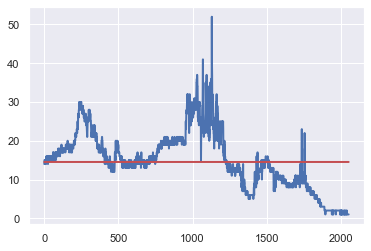

In [470]:
testacc2 = np.array(test_accuracy2)
realData = scaler.inverse_transform(testacc2[199][2])
predictData_CNN = scaler.inverse_transform(testacc2[199][1])
testScore_CNN = math.sqrt(mean_squared_error(realData, predictData_CNN))
# print('Train Score: %.2f RMSE' % testScore_RESNET)

plt.plot(realData, 'b-', label='reported data',linewidth =2.0)
plt.plot(predictData_CNN, 'r-', label ='raw data', linewidth =2.0)

In [471]:

# plt.plot(train_loss1, 'r', linestyle='-', label='MLP')
# plt.plot(train_loss2, 'b', linestyle='-', label='CNN')
# plt.title('train Loss')
# plt.xlabel('epoch')
# plt.ylabel("train loss")
# plt.ylim(0,0.1)
# plt.xlim(0,50)
# plt.legend()
# plt.show()
# #testPredict = scaler.inverse_transform(testPredict)

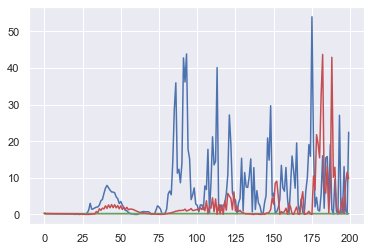

In [472]:
MSE_1 = []
MSE_2 = []
MSE_3 = []
MSE_4 = []

for i in range(len(testacc1)):
    MSE_1.append(testacc1[i][0])
    MSE_2.append(testacc2[i][0])
    MSE_3.append(testacc3[i][0])
    MSE_4.append(testacc4[i][0])
plt.plot(MSE_1)
plt.plot(MSE_2)
plt.plot(MSE_3)
plt.plot(MSE_4)

# Task 2: Make a simple VGG and ResNet for IoT

### VGG

In [473]:
# https://pytorch.org/docs/0.4.0/_modules/torchvision/models/vgg.html
#torch.nn.AvgPool2d(kernel_size, stride=None, padding=0, ceil_mode=False, count_include_pad=True)
#self.conv1_1 = nn.Conv2d(input_channels = 3, output_channels = 32, kernel_size =3, stride = 1, padding = 1)

In [474]:
class SimpleVGG(nn.Module):
    def __init__(self):
        super(SimpleVGG, self).__init__()
        
        self.conv1_1 = nn.Conv2d(3, 16, 3, 1, 1)        
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
        # # 3 x 8 x 32 - > 16 x 8 x 32
        self.act1_1 = nn.ReLU() 
        self.conv1_2 = nn.Conv2d(16, 16, 3, 1, 1)
        # # 16 x 8 x 32 - > 16 x 8 x 32
        self.act1_2 = nn.ReLU()
        self.pool = nn.AvgPool2d(2,2)
        # maxpool2d(kernel_size, stride, padding, dilation, ceil_mode)
        # 16 x 4 x 16
        self.conv2_1 = nn.Conv2d(16, 32, 3, 1, 1)
        self.act2_1 = nn.ReLU() 
        # 32 x 4 x 16
        self.conv2_2 = nn.Conv2d(32, 32, 3, 1, 1)
        # 32 x 4 x 16
        self.act2_2 = nn.ReLU()
        self.conv2_3 = nn.Conv2d(32, 32, 3, 1, 1)
        # 32 x 4 x 16
        self.act2_3 = nn.ReLU()
        self.pool2 = nn.AvgPool2d(2,2)
        # 32 x 2 x 8
        self.conv3_1 = nn.Conv2d(32, 64, 3, 1, 1)
        # 64 x 2 x 8
        self.act3_1 = nn.ReLU() 
        self.conv3_2 = nn.Conv2d(64, 64, 3, 1, 1)
        # 64 x 2 x 8
        self.act3_2 = nn.ReLU()
        self.conv3_3 = nn.Conv2d(64, 64, 3, 1, 1)
        # 64 x 2 x 8
        self.act3_3 = nn.ReLU()
        self.pool3 = nn.AvgPool2d(2, 8)

        self.fc1 = nn.Linear(64*1*1, 1)
        
    def forward(self, x):
        
        x = self.act1_1(self.conv1_1(x))
        x = self.pool(self.act1_2(self.conv1_2(x)))
        
        x = self.act2_1(self.conv2_1(x))
        x = self.act2_2(self.conv2_2(x))
        x = self.pool2(self.act2_3(self.conv2_3(x)))
        
        x = self.act3_1(self.conv3_1(x))
        x = self.act3_2(self.conv3_2(x))
        x = self.pool3(self.act3_3(self.conv3_3(x)))
                
        x = x.view(-1, 64*1*1)
        x = self.fc1(x)
        return x
    

torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)


In [475]:
vgg_model = SimpleVGG().cuda()
train_loss3 = []
test_accuracy3 = []
for epoch in tqdm(range(NUM_EPOCH)):
    train_loss3.append(fit(vgg_model, train_loader))
    test_accuracy3.append(eval(vgg_model, test_loader))

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [25:13<00:00,  7.38s/it]


In [476]:
summary(vgg_model, input_size = (3,8,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 16, 8, 32]             448
              ReLU-2            [-1, 16, 8, 32]               0
            Conv2d-3            [-1, 16, 8, 32]           2,320
              ReLU-4            [-1, 16, 8, 32]               0
         MaxPool2d-5            [-1, 16, 4, 16]               0
            Conv2d-6            [-1, 32, 4, 16]           4,640
              ReLU-7            [-1, 32, 4, 16]               0
            Conv2d-8            [-1, 32, 4, 16]           9,248
              ReLU-9            [-1, 32, 4, 16]               0
           Conv2d-10            [-1, 32, 4, 16]           9,248
             ReLU-11            [-1, 32, 4, 16]               0
        MaxPool2d-12             [-1, 32, 2, 8]               0
           Conv2d-13             [-1, 64, 2, 8]          18,496
             ReLU-14             [-1, 6

In [477]:
testacc3 = np.array(test_accuracy3)
print("testacc3.shape:", testacc3.shape)

testacc3.shape: (200, 3)


Train Score: 7.64 RMSE


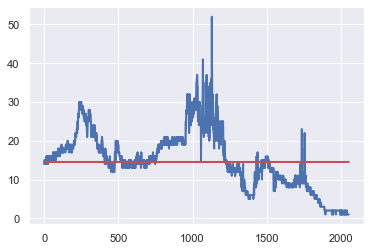

In [478]:
testacc3 = np.array(test_accuracy3)
realData = scaler.inverse_transform(testacc3[199][2])
predictData_VGG = scaler.inverse_transform(testacc3[199][1])
plt.plot(realData)
plt.plot(predictData_VGG)

testScore_VGG = math.sqrt(mean_squared_error(realData, predictData_VGG))
print('Train Score: %.2f RMSE' % testScore_VGG)

plt.plot(realData, 'b-', label='reported data',linewidth =2.0)
plt.plot(predictData_VGG, 'r-', label ='raw data', linewidth =2.0)




### ResNet

In [479]:
# https://missinglink.ai/guides/deep-learning-frameworks/pytorch-resnet-building-training-scaling-residual-networks-pytorch/

In [480]:
class SimpleResNet(nn.Module):
    def __init__(self):
        super(SimpleResNet, self).__init__()
        self.conv1_1 = nn.Conv2d(3, 16, 3, 1, 1)        
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
        # # 3 x 8 x 32 - > 16 x 8 x 32
        self.act1_1 = nn.ReLU() 
        self.conv1_2 = nn.Conv2d(16, 16, 3, 1, 1)
        # # 16 x 8 x 32 - > 16 x 8 x 32
        self.act1_2 = nn.ReLU()
        self.pool = nn.AvgPool2d(2,2)
        # maxpool2d(kernel_size, stride, padding, dilation, ceil_mode)
        # 16 x 4 x 16
        self.conv2_1 = nn.Conv2d(16, 32, 3, 1, 1)
        self.act2_1 = nn.ReLU() 
        # 32 x 4 x 16
        self.conv2_2 = nn.Conv2d(32, 32, 3, 1, 1)
        # 32 x 4 x 16
        self.act2_2 = nn.ReLU()
        self.conv2_3 = nn.Conv2d(32, 32, 3, 1, 1)
        # 32 x 4 x 16
        self.act2_3 = nn.ReLU()
        self.pool2 = nn.AvgPool2d(2,2)
        # 32 x 2 x 8
        self.conv3_1 = nn.Conv2d(32, 64, 3, 1, 1)
        # 64 x 2 x 8
        self.act3_1 = nn.ReLU() 
        self.conv3_2 = nn.Conv2d(64, 64, 3, 1, 1)
        # 64 x 2 x 8
        self.act3_2 = nn.ReLU()
        self.conv3_3 = nn.Conv2d(64, 64, 3, 1, 1)
        # 64 x 2 x 8
        self.act3_3 = nn.ReLU()
        self.pool3 = nn.AvgPool2d(2, 8)

        self.fc1 = nn.Linear(64*1*1, 1)
        
    def forward(self, x):
        
        x = self.act1_1(self.conv1_1(x))
        x = self.pool(self.act1_2(self.conv1_2(x)))
        
        x1 = self.act2_1(self.conv2_1(x))
        x = self.act2_2(self.conv2_2(x1))
        x = self.conv2_3(x)
        x = self.act2_3(x+x1)
        x = self.pool2(x)
        
        x2 = self.act3_1(self.conv3_1(x))
        x = self.act3_2(self.conv3_2(x2))
        x = self.act3_3(self.conv3_3(x)+x2)
        x = self.pool3(x)
            
        
        x = x.view(-1, 64*1*1)
        x = self.fc1(x)
        return x

In [481]:
resnet_model = SimpleResNet().cuda()
train_loss4 = []
test_accuracy4 = []
for epoch in tqdm(range(NUM_EPOCH)):
    train_loss4.append(fit(resnet_model, train_loader))
    test_accuracy4.append(eval(resnet_model, test_loader))

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [25:28<00:00,  7.56s/it]


In [482]:
testacc4 = np.array(test_accuracy4)
print("testacc4.shape:", testacc4.shape)

testacc4.shape: (200, 3)


Train Score: 6.41 RMSE


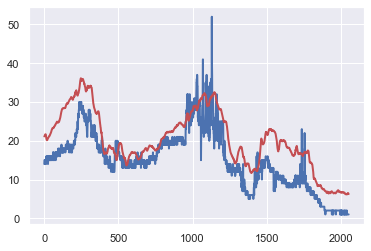

In [483]:
testacc4 = np.array(test_accuracy4)
realData = scaler.inverse_transform(testacc4[199][2])
predictData_RESNET = scaler.inverse_transform(testacc4[199][1])
# plt.plot(realData)
# plt.plot(predictData_RESNET)
testScore_RESNET = math.sqrt(mean_squared_error(realData, predictData_RESNET))
print('Train Score: %.2f RMSE' % testScore_RESNET)

plt.plot(realData, 'b-', label='reported data',linewidth =2.0)
plt.plot(predictData_RESNET, 'r-', label ='raw data', linewidth =2.0)



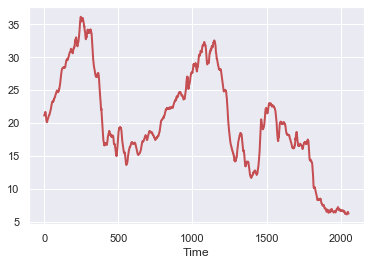

In [547]:
plt.plot(predictData_RESNET, 'r-', label ='raw data', linewidth =2.0)
plt.grid('true')

plt.xlabel("Time")
# plt.ylabel("Temperature")
# plt.legend(loc='upper left')
plt.show()

In [484]:
# train_loader = torch.utils.data.DataLoader(dataset=trainData, batch_size=BATCH_SIZE, shuffle=False)
# test_loader = torch.utils.data.DataLoader(dataset=testData, batch_size=BATCH_SIZE, shuffle=False)
# trainX, trainY = create_dataset(train, look_back,estimated_len, 2)
# testX, testY = create_dataset(test, look_back,estimated_len, 2)
LSTM_trainX = np.reshape(trainX, (len(trainX),1,len(trainX[1].reshape(-1))))
LSTM_trainY = np.reshape(trainY, (len(trainY),len(trainY[1].reshape(-1))))
LSTM_testX = np.reshape(testX, (len(testX),1,len(testX[1].reshape(-1))))
LSTM_testY = np.reshape(testY, (len(testY),len(testY[1].reshape(-1))))
print('LSTM_trainX shape: {}, LSTM_trainY shape: {}, LSTM_testX shape: {}, LSTM_testY shape: {}'.format(LSTM_trainX.shape, LSTM_trainY.shape,LSTM_testX.shape,LSTM_testY.shape))


LSTM_trainX shape: (18758, 1, 768), LSTM_trainY shape: (18758, 1), LSTM_testX shape: (2054, 1, 768), LSTM_testY shape: (2054, 1)


In [485]:
# simple lstm network learning
model = Sequential()
model.add(LSTM(5, input_shape=(1, LSTM_trainX.shape[2])))
#model.add(flatten())
model.add(Dense(estimated_len))
model.compile(loss='mean_squared_error', optimizer='adam')
#early_stopping = EarlyStopping(monitor='val_loss', patience = 100, verbose= 1)
model.fit(LSTM_trainX, LSTM_trainY, epochs=200, batch_size=20, verbose=2)
# early_stopping = EarlyStopping(monitor='val_loss', patience = 100, verbose= 1)
# model.fit(trainX, trainY, epochs=500, batch_size=15, verbose=2, validation_split = 0.2,  callbacks=[early_stopping])

NameError: name 'Sequential' is not defined

In [399]:
# make prediction
LSTM_testPredict = model.predict(LSTM_testX)
# temp_scaler = scaler.fit_transform(nparr[target-1])
LSTM_testPredict = scaler.inverse_transform(LSTM_testPredict)
LSTM_testY = scaler.inverse_transform(LSTM_testY)
testScore = math.sqrt(mean_squared_error(realData, LSTM_testPredict))
print('Train Score: %.2f RMSE' % testScore)

plt.plot(realData, 'b-', label='reported data',linewidth =2.0)
plt.plot(LSTM_testPredict, 'r-', label ='raw data', linewidth =2.0)

print('LSTM_testY.shape: {}, LSTM_testPredict.shape: {}'.format(LSTM_testY.shape, LSTM_testPredict.shape))



# testacc4 = np.array(test_accuracy4)
# realData = scaler.inverse_transform(testacc1[199][2])
# predictData_RESNET = scaler.inverse_transform(testacc4[199][1])
# plt.plot(realData)
# plt.plot(predictData_RESNET)




NameError: name 'model' is not defined

In [ ]:
# plt.plot(train_loss3, 'r', linestyle='-', label='VGG')
# plt.plot(train_loss4, 'b', linestyle='-', label='ResNet')
# plt.title('Train Loss')
# plt.xlabel('epoch')
# plt.ylabel("train loss")
# plt.ylim(0,5)
# plt.xlim(0,50)
# plt.legend()
# plt.show()

In [ ]:
# plt.plot(test_accuracy3, 'r', linestyle='-', label='VGG')
# plt.plot(test_accuracy4, 'b', linestyle='-', label='ResNet')
# plt.title('Test Accuracy')
# plt.xlabel('epoch')
# plt.ylabel("test accuracy")
# plt.ylim(0,100)
# plt.xlim(0,50)
# plt.legend()
# plt.show()

# Task 3 : Use various regularizers

### ResNet + Batch Normalization

In [ ]:
class ResNetBN(nn.Module):
    def __init__(self):
        super(ResNetBN, self).__init__()
        self.conv1_1 = nn.Conv2d(3, 32, 3, 1, 1)
        self.batch1_1 = nn.BatchNorm2d(32)
        self.act1_1 = nn.ReLU() 
        
        self.conv1_2 = nn.Conv2d(32, 32, 3, 1, 1)
        self.batch1_2 = nn.BatchNorm2d(32)
        self.act1_2 = nn.ReLU()
        self.pool = nn.MaxPool2d(2,2)
        
        
        
        self.conv2_1 = nn.Conv2d(32, 64, 3, 1, 1)
        self.batch2_1 = nn.BatchNorm2d(64)
        self.act2_1 = nn.ReLU() 
        self.conv2_2 = nn.Conv2d(64, 64, 3, 1, 1)
        self.batch2_2 = nn.BatchNorm2d(64)
        self.act2_2 = nn.ReLU()
        self.conv2_3 = nn.Conv2d(64, 64, 3, 1, 1)
        self.batch2_3 = nn.BatchNorm2d(64)
        self.act2_3 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2,2)
        
        
        
        
        
        self.conv3_1 = nn.Conv2d(64, 128, 3, 1, 1)
        self.batch3_1 = nn.BatchNorm2d(128)
        self.act3_1 = nn.ReLU() 
        self.conv3_2 = nn.Conv2d(128, 128, 3, 1, 1)
        self.batch3_2 = nn.BatchNorm2d(128)
        self.act3_2 = nn.ReLU()
        self.conv3_3 = nn.Conv2d(128, 128, 3, 1, 1)
        self.batch3_3 = nn.BatchNorm2d(128)
        self.act3_3 = nn.ReLU()
        self.pool3 = nn.AvgPool2d(8, 8)
        
        
        
        
        
        
        
        self.fc1 = nn.Linear(128*1*1, 10)
        
    def forward(self, x):
        
        x = self.act1_1(self.batch1_1(self.conv1_1(x)))
        x = self.pool(self.act1_2(self.batch1_2(self.conv1_2(x))))
        
        x1 = self.act2_1(self.batch2_1(self.conv2_1(x)))
        x = self.act2_2(self.batch2_2(self.conv2_2(x1)))
        x = self.batch2_3(self.conv2_3(x))
        x = self.act2_3(x+x1)
        x = self.pool2(x)
        
        x2 = self.act3_1(self.batch3_1(self.conv3_1(x)))
        x = self.act3_2(self.batch3_2(self.conv3_2(x2)))
        x = self.act3_3(self.batch3_3(self.conv3_3(x))+x2)
        x = self.pool3(x)
            
        
        x = x.view(-1, 128*1*1)
        x = self.fc1(x)
        return x

In [ ]:
resnet_bn_model = ResNetBN().cuda()
train_loss5 = []
test_accuracy5 = []
for epoch in tqdm(range(NUM_EPOCH)):
    train_loss5.append(fit(resnet_bn_model, train_loader))
    test_accuracy5.append(eval(resnet_bn_model, test_loader))

### ResNet + Dropout(p=0.5)

In [ ]:
class ResNetDO(nn.Module):
    def __init__(self):
        super(ResNetDO, self).__init__()
        self.conv1_1 = nn.Conv2d(3, 32, 3, 1, 1)
        self.act1_1 = nn.ReLU() 
        self.conv1_2 = nn.Conv2d(32, 32, 3, 1, 1)
        self.act1_2 = nn.ReLU()
        self.pool = nn.MaxPool2d(2,2)
        
        self.conv2_1 = nn.Conv2d(32, 64, 3, 1, 1)
        self.act2_1 = nn.ReLU() 
        self.conv2_2 = nn.Conv2d(64, 64, 3, 1, 1)
        self.act2_2 = nn.ReLU()
        self.conv2_3 = nn.Conv2d(64, 64, 3, 1, 1)
        self.act2_3 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2,2)
        
        self.conv3_1 = nn.Conv2d(64, 128, 3, 1, 1)
        self.act3_1 = nn.ReLU() 
        self.conv3_2 = nn.Conv2d(128, 128, 3, 1, 1)
        self.act3_2 = nn.ReLU()
        self.conv3_3 = nn.Conv2d(128, 128, 3, 1, 1)
        self.act3_3 = nn.ReLU()
        self.pool3 = nn.AvgPool2d(8, 8)
        self.drop = nn.Dropout2d(p=0.5)
        self.fc1 = nn.Linear(128*1*1, 10)
        
    def forward(self, x):
        
        x = self.act1_1(self.conv1_1(x))
        x = self.pool(self.act1_2(self.conv1_2(x)))
        
        x1 = self.act2_1(self.conv2_1(x))
        x = self.act2_2(self.conv2_2(x1))
        x = self.conv2_3(x)
        x = self.act2_3(x+x1)
        x = self.pool2(x)
        
        x2 = self.act3_1(self.conv3_1(x))
        x = self.act3_2(self.conv3_2(x2))
        x = self.act3_3(self.conv3_3(x)+x2)
        x = self.pool3(x)
            
        
        x = x.view(-1, 128*1*1)
        x = self.drop(x)
        x = self.fc1(x)
        return x

In [ ]:
resnet_do_model = ResNetDO().cuda()
train_loss6 = []
test_accuracy6 = []
for epoch in tqdm(range(NUM_EPOCH)):
    train_loss6.append(fit(resnet_do_model, train_loader))
    test_accuracy6.append(eval(resnet_do_model, test_loader))

### VGG + Weight Decay (5e-4)

In [ ]:
def fit_WD(model,train_loader):
    device = next(model.parameters()).device.index
    model.train()
    ##### fill in this part using SGD optimizer with momentum of 0.9 and weight decay of 5e-4 #####
    optimizer = torch.optim.SGD(model.parameters(), lr = LEARNING_RATE, momentum = 0.9, weight_decay = 5e-4)
    losses = []
    for i, data in enumerate(train_loader):
        image = data[0].type(torch.FloatTensor).cuda(device)
        label = data[1].type(torch.LongTensor).cuda(device)

        pred_label = model(image)
        loss = CRITERION(pred_label, label)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    avg_loss = sum(losses)/len(losses)
    return avg_loss

In [ ]:
resnet_wd_model = SimpleResNet().cuda()
train_loss7 = []
test_accuracy7 = []
for epoch in tqdm(range(NUM_EPOCH)):
    train_loss7.append(fit_WD(resnet_wd_model, train_loader))
    test_accuracy7.append(eval(resnet_wd_model, test_loader))

In [ ]:
plt.plot(test_accuracy4, 'r', linestyle='-', label='vanilla ResNet')
plt.plot(test_accuracy5, 'b', linestyle='-', label='ResNet+Batch Normalizaton')
plt.plot(test_accuracy6, 'c', linestyle='-', label='ResNet+Drop out')
plt.plot(test_accuracy7, 'y', linestyle='-', label='ResNet+Weight decay')

plt.title('Test Accuracy')
plt.xlabel('epoch')
plt.ylabel("test accuracy")
plt.ylim(0,100)
plt.xlim(0,50)
plt.legend()
plt.show()

In [ ]:
plt.plot(train_loss4, 'r', linestyle='-', label='vanilla ResNet')
plt.plot(train_loss5, 'b', linestyle='-', label='ResNet+Batch Normalizaton')
plt.plot(train_loss6, 'c', linestyle='-', label='ResNet + Drop out')
plt.plot(train_loss7, 'y', linestyle='-', label='ResNet+Weight decay')

plt.title('Train Loss')
plt.xlabel('epoch')
plt.ylabel("train loss")
plt.ylim(0,5)
plt.xlim(0,50)
plt.legend()
plt.show()

In [487]:
## 주기조절 식##
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style='whitegrid',color_codes=True)
import os, inspect
from collections import deque
#import bb_model 
import math
import prediction_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
import prediction_model
import math
from sklearn.metrics import mean_squared_error
#import Cleaning

Using TensorFlow backend.


In [488]:
realData = scaler.inverse_transform(testacc4[199][2])
predictData_RESNET = scaler.inverse_transform(testacc4[199][1])

In [489]:
# tmax=5
# phi=2
# visualizeLength = len(testY)
# prediction_model=prediction_model.prediction_model(tmax=tmax,phi=phi)

In [490]:
tmax=5
phi=2
visualizeLength = len(realData)
prediction_model=prediction_model.prediction_model(tmax=tmax,phi=phi)

In [492]:
predicted_data = predictData_RESNET
real_data = realData

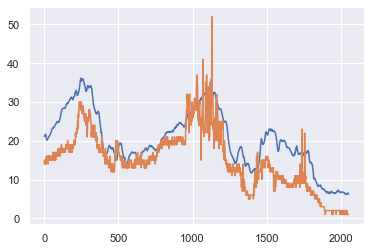

In [505]:
plt.plot(predictData_RESNET)
plt.plot(real_data)

In [513]:
testY = real_data

In [514]:
sampt = 0
twait=tmax
sampIdxes=np.zeros(np.size(real_data)) # data를 얼마나 입력받을지 모르니까, 미리 만들어 놓는게 사실 말은 안되지만..., mark 1 when sampled 
sampData=np.zeros(np.size(real_data))*np.nan # 여기도 마찬가지

In [515]:
for t in range(len(testY)):
    if t==sampt:
        sampIdxes[t]=1
        sampData[t] = testY[t]
        Residual = prediction_model.calculate_residual(predicted_data[t], real_data[t], phi)
        twait = prediction_model.calculate_twait(tmax,Residual)
        sampt = t+twait
    print('Current time: ', t, '\t|| Sample rate: ', twait, '\t|| Next sample time: ', sampt)

Current time:  0 	|| Sample rate:  1 	|| Next sample time:  1
Current time:  1 	|| Sample rate:  1 	|| Next sample time:  2
Current time:  2 	|| Sample rate:  1 	|| Next sample time:  3
Current time:  3 	|| Sample rate:  1 	|| Next sample time:  4
Current time:  4 	|| Sample rate:  1 	|| Next sample time:  5
Current time:  5 	|| Sample rate:  1 	|| Next sample time:  6
Current time:  6 	|| Sample rate:  1 	|| Next sample time:  7
Current time:  7 	|| Sample rate:  1 	|| Next sample time:  8
Current time:  8 	|| Sample rate:  1 	|| Next sample time:  9
Current time:  9 	|| Sample rate:  1 	|| Next sample time:  10
Current time:  10 	|| Sample rate:  1 	|| Next sample time:  11
Current time:  11 	|| Sample rate:  1 	|| Next sample time:  12
Current time:  12 	|| Sample rate:  1 	|| Next sample time:  13
Current time:  13 	|| Sample rate:  1 	|| Next sample time:  14
Current time:  14 	|| Sample rate:  1 	|| Next sample time:  15
Current time:  15 	|| Sample rate:  1 	|| Next sample time:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



377
Current time:  377 	|| Sample rate:  1 	|| Next sample time:  378
Current time:  378 	|| Sample rate:  1 	|| Next sample time:  379
Current time:  379 	|| Sample rate:  1 	|| Next sample time:  380
Current time:  380 	|| Sample rate:  1 	|| Next sample time:  381
Current time:  381 	|| Sample rate:  1 	|| Next sample time:  382
Current time:  382 	|| Sample rate:  1 	|| Next sample time:  383
Current time:  383 	|| Sample rate:  1 	|| Next sample time:  384
Current time:  384 	|| Sample rate:  1 	|| Next sample time:  385
Current time:  385 	|| Sample rate:  1 	|| Next sample time:  386
Current time:  386 	|| Sample rate:  1 	|| Next sample time:  387
Current time:  387 	|| Sample rate:  2 	|| Next sample time:  389
Current time:  388 	|| Sample rate:  2 	|| Next sample time:  389
Current time:  389 	|| Sample rate:  5 	|| Next sample time:  394
Current time:  390 	|| Sample rate:  5 	|| Next sample time:  394
Current time:  391 	|| Sample rate:  5 	|| Next sample time:  394
Curren

Current time:  625 	|| Sample rate:  5 	|| Next sample time:  627
Current time:  626 	|| Sample rate:  5 	|| Next sample time:  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Current time:  748 	|| Sample rate:  1 	|| Next sample time:  749
Current time:  749 	|| Sample rate:  1 	|| Next sample time:  750
Current time:  750 	|| Sample rate:  2 	|| Next sample time:  752
Current time:  751 	|| Sample rate:  2 	|| Next sample time:  752
Current time:  752 	|| Sample rate:  2 	|| Next sample time:  754
Current time:  753 	|| Sample rate:  2 	|| Next sample time:  754
Current time:  754 	|| Sample rate:  2 	|| Next sample time:  756
Current time:  755 	|| Sample rate:  2 	|| Next sample time:  756
Current time:  756 	|| Sample rate:  2 	|| Next sample time:  758
Current time:  757 	|| Sample rate:  2 	|| Next sample time:  758
Current time:  758 	|| Sample rate:  2 	|| Next sample time:  760
Current time:  759 	|| Sample rate:  2 	|| Next sample time:  760
Current time:  760 	|| Sample rate:  2 	|| Next sample time:  762
Current time:  761 	|| Sample rate:  2 	|| Next sample time:  762
Current time:  762 	|| Sample rate:  5 	|| Next sample time:  767
Current t

Current time:  1203 	|| Sample rate:  2 	|| Next sample time:  1204
Current time:  1204 	|| Sample rate:  1 	|| Next sample time:  1205
Current time:  1205 	|| Sample rate:  2 	|| Next sample time:  1207
Current time:  1206 	|| Sample rate:  2 	|| Next sample time:  1207
Current time:  1207 	|| Sample rate:  1 	|| Next sample time:  1208
Current time:  1208 	|| Sample rate:  1 	|| Next sample time:  1209

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 	|| Sample rate:  4 	|| Next sample time:  1437
Current time:  1436 	|| Sample rate:  4 	|| Next sample time:  1437
Current time:  1437 	|| Sample rate:  1 	|| Next sample time:  1438
Current time:  1438 	|| Sample rate:  1 	|| Next sample time:  1439
Current time:  1439 	|| Sample rate:  1 	|| Next sample time:  1440
Current time:  1440 	|| Sample rate:  1 	|| Next sample time:  1441
Current time:  1441 	|| Sample rate:  1 	|| Next sample time:  1442
Current time:  1442 	|| Sample rate:  1 	|| Next sample time:  1443
Current time:  1443 	|| Sample rate:  1 	|| Next sample time:  1444
Current time:  1444 	|| Sample rate:  1 	|| Next sample time:  1445
Current time:  1445 	|| Sample rate:  1 	|| Next sample time:  1446
Current time:  1446 	|| Sample rate:  1 	|| Next sample time:  1447
Current time:  1447 	|| Sample rate:  2 	|| Next sample time:  1449
Current time:  1448 	|| Sample rate:  2 	|| Next sample time:  1449
Current time:  1449 	|| Sample rate:  1 	|| Next sample time:  1450

Current time:  2034 	|| Sample rate:  1 	|| Next sample time:  2035
Current time:  2035 	|| Sample rate:  1 	|| Next sample time:  2036
Current time:  2036 	|| Sample rate:  1 	|| Next sample time:  2037
Current time:  2037 	|| Sample rate:  1 	|| Next sample time:  2038
Current time:  2038 	|| Sample rate:  1 	|| Next sample time:  2039
Current time:  2039 	|| Sample rate:  1 	|| Next sample time:  2040
Current time:  2040 	|| Sample rate:  1 	|| Next sample time:  2041
Current time:  2041 	|| Sample rate:  1 	|| Next sample time:  2042
Current time:  2042 	|| Sample rate:  1 	|| Next sample time:  2043
Current time:  2043 	|| Sample rate:  1 	|| Next sample time:  2044

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [516]:
appxData=np.zeros(np.size(testY))*np.nan
sampIdxes=np.where(sampIdxes[:visualizeLength]==1)[0]
for prevt, postt in zip(sampIdxes, sampIdxes[1:]):
    if postt-prevt==1:
        appxData[prevt]=sampData[prevt]
    else:
        slope=(sampData[postt]-sampData[prevt])/(postt-prevt-1)
        appxData[prevt:postt]=((np.array(range(prevt,postt))-prevt)*slope)+sampData[prevt]
        # 맨 마지막 data 채워야 함	
        
        
        # sampData.shape

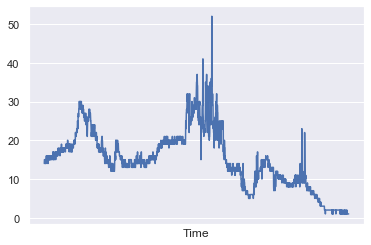

In [517]:
prediction_model.visualize(testY,sampData,sampIdxes,visualizeLength=visualizeLength) 

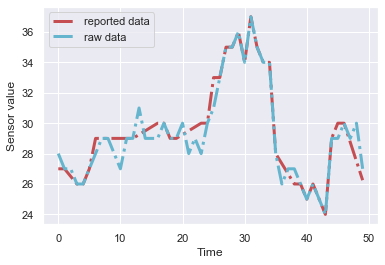

In [537]:
plt.plot(appxData[1000:1050], 'r-.', label='reported data',linewidth =3.0)
plt.plot(testY[1000:1050], 'c-.', label ='raw data', linewidth =3.0)

#plt.xticks([0,len(appxData[60:120])/2,len(appxData[60:120])/2*2, ], ["7/9 12:00", "7/9 13:00", "7/9 14:00"])
plt.grid('true')
plt.xlabel("Time")
plt.ylabel("Sensor value")
plt.legend(loc='upper left')
plt.show()

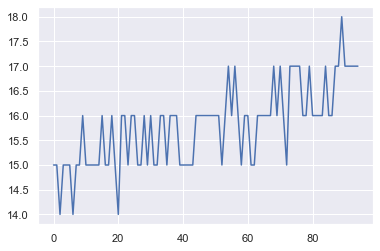

In [523]:
plt.plot(appxData[5:100])

In [ ]:
# ## sensor index sorting by sensor ID ## 
# '''
# sensor_dfs_index: ['tvoc_41', 'tvoc_44', 't_43', 'pm025_44', 'h_41', 'co2_45', 
# 'tvoc_42', 'co2_43', 'h_42', 'co2_44', 'co2_42', 't_42', 'h_43', 't_41', 'tvoc_43', 
# 't_45', 'pm025_41', 'pm100_43', 't_44', 'tvoc_45', 'h_44', 'pm025_45', 'pm100_45', 
# 'pm025_43', 'co2_41', 'pm100_42', 'pm025_42', 'pm100_41', 'pm100_44', 'h_45']
# '''
# new_df_index = []
# num_sensor = 5
# split_index = []

# j= 41
# for j in range(41, 41+num_sensor):
#     split_index.append([])
#     for i in range(len(df_index)):
#         if df_index[i].split('_')[1] == str(j):
#             new_df_index.append(df_index[i])
#             split_index.append(df_index[i])
#     j = j+1
# print('new_df_index:', new_df_index)

# sensor_dfs = sensor_dfs[new_df_index]